In [1]:
#| label: import
#| echo: false
#| include: true
#| code-fold: false

## General imports
import warnings
warnings.filterwarnings('ignore')

## Data manipulation imports
import pandas as pd
import numpy as np

## Display imports
from IPython.display import display, Markdown

## statmodels import
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.genmod.families.family as fam
from patsy import dmatrices

## Plot imports
import matplotlib.style as style
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (5,5/2.5)
import seaborn as sns
sns.set_style('whitegrid')
sns.set_theme()
sns.set_context(
    "paper", 
    rc={
        "figsize"       :   plt.rcParams['figure.figsize'],
        'font_scale'    :   1.25,
    }
)
height = plt.rcParams['figure.figsize'][0]
aspect = plt.rcParams['figure.figsize'][0] / plt.rcParams['figure.figsize'][1] / 2

# Motivation & Installation
Did you ever dream to build your own fast API written in Python? 

[FastAPI](https://fastapi.tiangolo.com/) is a modern, high-performance web framework for building APIs with Python. It blends the ease of use of Python with exceptional speed, making it an ideal choice for developing robust and efficient web applications. 

Its automatic validation, interactive documentation, and type hints enhance developer productivity and code reliability. Whether you're crafting a simple REST API or a complex microservices architecture, FastAPI streamlines development, promotes clean code, and optimizes performance, making it the go-to framework for those seeking both speed and simplicity in their Python web projects.

The installation of FastAPI is very simple and it involves the installation of two packages: (1) FastAPI and (2) Uvicorn. The first one is the framework itself and the second one is the server that will run the API.

```bash
pip install fastapi
pip install "uvicorn[standard]"
```

Next, we discuss the data and the corresponding database technology that we will use to store the data.

# Data
Switzerland's unique tax system is characterized by its federal structure, granting significant fiscal autonomy to its municipalities and cantons. This system encourages competition among cantons and municipalities while also fostering a sense of local ownership and control over financial matters. As a result, Switzerland's tax landscape is complex, diverse, and reflective of the nation's commitment to decentralized governance.

In [2]:
#| output: false
#| echo: false
#| code-fold: false

try:
    # helper function for reading datasets with proper separator
    def get_dataset(url):
        if url[-3:] != "csv":
            print(
                """"
                The data set URL has no proper 'csv' extension. 
                Reading the dataset might not have worked as expected.
                Please check the dataset link and adjust pandas' 
                read_csv() parameters accordingly.
                """
            )
        data = pd.read_csv(
            url, 
            sep = ",", 
            on_bad_lines = 'warn', 
            encoding_errors = 'ignore', 
            low_memory = False,
        )
        # if dataframe only has one column or less the data is not comma separated, use ";" instead
        if data.shape[1] <= 1:
            data = pd.read_csv(
                url, 
                sep=';', 
                on_bad_lines='warn', 
                encoding_errors='ignore', 
                low_memory=False,
            )
            if data.shape[1] <= 1:
                print("""
                The data wasn't imported properly. 
                Very likely the correct separator couldn't be found.
                Please check the dataset manually and adjust the code.
                """)
        return data

    df = (
        get_dataset(
            'https://www.web.statistik.zh.ch/ogd/data/KANTON_ZUERICH_286.csv'
        )
        [['GEBIET_NAME', 'INDIKATOR_JAHR', 'INDIKATOR_VALUE']]
        .rename(
            columns = {
                'GEBIET_NAME'       :   'Municipality',
                'INDIKATOR_JAHR'    :   'Year',
                'INDIKATOR_VALUE'   :   'IncomeTax',
            }
        )
        .assign(
            Year = lambda df: pd.to_datetime(df['Year'], format='%Y').dt.year,
            IncomeTax = lambda df: df['IncomeTax'].astype(int),   
        )
    )

    df.to_parquet(
        '../../data/IncomeTax.parquet',
    )
except:
    df = pd.read_parquet(
        '../../data/IncomeTax.parquet',
    )

In [3]:
#| echo: false

display(
    Markdown(
        "We are going to work in this post with data from the nicest and best canton of Switzerland called Zurich :)" + " " +
        f"We have data from {df.Municipality.nunique()} municipalities during the period between {df.Year.min()}-{df.Year.max()}. " + " "
        f"The data presents the mean income tax per municipality and year."
    )
)

We are going to work in this post with data from the nicest and best canton of Switzerland called Zurich :) We have data from 201 municipalities during the period between 1990-2022.  The data presents the mean income tax per municipality and year.

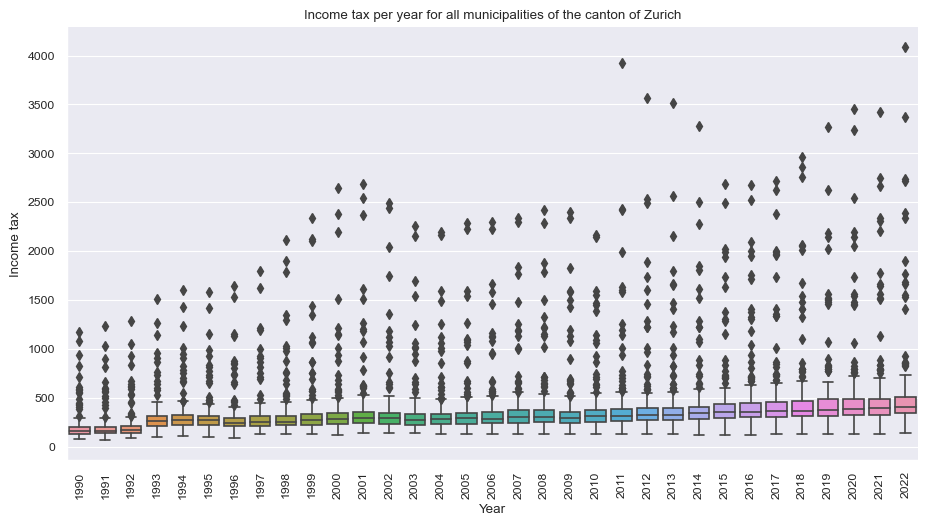

In [4]:
#| label: fig-income_tax_zurich
#| include: false
#| output: false
#| echo: false
#| fig-cap: Distribution of average income tax per municipality in the canton of Zurich per year. 

sns.catplot(
    data = df,
    x = 'Year',
    y = 'IncomeTax',
    height = height,
    aspect = aspect * 1.5,
    kind = 'box',
)
plt.title('Income tax per year for all municipalities of the canton of Zurich')
plt.xticks(rotation=90)
plt.xlabel('Year')
plt.ylabel('Income tax')
plt.show()

<!-- @fig-income_tax_zurich shows for each municipality the average paid income tax per person per year. It can be observed that the spread and average income tax is increasing. Since the focus of this article is in creating a custom API service we continue without futher analysis. -->

# Database

The data is stored in a database, a crucial endeavor that lays the foundation for simulating a dynamic production environment. We are going to use `sqlalchemy`: a remarkable tool empowers us to seamlessly alter the connection string enabling effortlessly establishment of connections across a diverse database types. 

First, the connection is defined by `sqlalchemy.create_engine()` and subsequently used in order to save the data to the database using pandas method `to_sql()`.

In [5]:
#| label: lst-database
#| code-fold: false
#| echo: true
#| output: false

import statsmodels.api as sm
from sqlalchemy import create_engine

# Create a connection to the database
engine = create_engine(              
    ## Path to database                     
    'sqlite:///../../data/FastAPI.db',      # <1>
)

## Create a table in new database
df.to_sql(
    name = 'fastapi',
    con = engine,
    if_exists = 'replace',
    index = False,
);

After the creation of the `fastapi` table within the `FastAPI` database, we can continue with the creation of the API.

# Structure of API
The building blocks of our API-service consists of basic CRUD (Create, Read, Update, Delete) operations as follows:

| Function                                        | Description                                               |
|-------------------------------------------------|-----------------------------------------------------------|
| Get Data for a Given Year                       | Returns income tax data for a given year.                 |
| Get Data for a Given Municipality               | Returns income tax data for a given municipality.         |
| Get Data for a Given District                   | Returns income tax data for a given district.             |
| Get Data for the Canton                         | Returns income tax data for the entire canton.            |
| Create New Entry                                | Creates a new entry in the income tax table.              |
| Update Income Tax Entry                         | Updates the income tax value for a given municipality and year. |
| Update Year Entry                               | Updates the year value for a given municipality and year. |
| Delete Entry                                    | Deletes an entry from the income tax table.               |

Our api-service is going to use no authentication for its endpoints.

(use [lambda statement when possible](https://docs.sqlalchemy.org/en/20/core/sqlelement.html#sqlalchemy.sql.expression.lambda_stmt))